In [61]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

In [62]:
# Configuration
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [63]:
dataset_path = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.ckpt'
NUM_CLASSES = 5

In [64]:
# Load dataset
X = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, 21 * 2 + 1)))
y = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

In [65]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

In [66]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128)

In [67]:
from torchmetrics.classification import Accuracy


In [68]:
# Lightning module
class KeypointClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(21 * 2, 20),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, NUM_CLASSES)
        )
        self.accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [69]:
# Initialize model
model = KeypointClassifier()

In [70]:
# Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='model/keypoint_classifier/',
    filename='keypoint_classifier',
    save_top_k=1,
    monitor='val_loss',
    mode='min'
)

In [71]:
# Trainer
trainer = pl.Trainer(
    max_epochs=1000,
    callbacks=[early_stop_callback, checkpoint_callback],
    deterministic=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [72]:
# Train the model
trainer.fit(model, train_loader, val_loader)

C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\houci\Documents\ENSAM\3eme annee\S6\Computer Vision\CONTROLIT\model\keypoint_classifier exists and is not empty.

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 1.1 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████████████████████████████████████████| 22/22 [00:00<00:00, 68.69it/s, v_num=13, train_acc=0.133]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|███████████████████████████████| 22/22 [00:00<00:00, 47.28it/s, v_num=13, train_acc=0.133, val_acc=0.272]

Metric val_loss improved. New best score: 1.630


Epoch 1: 100%|███████████████████████████████| 22/22 [00:00<00:00, 53.26it/s, v_num=13, train_acc=0.267, val_acc=0.272]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████| 22/22 [00:00<00:00, 39.45it/s, v_num=13, train_acc=0.267, val_acc=0.376]

Metric val_loss improved by 0.178 >= min_delta = 0.0. New best score: 1.452


Epoch 2: 100%|███████████████████████████████| 22/22 [00:00<00:00, 71.19it/s, v_num=13, train_acc=0.400, val_acc=0.376]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████████████| 22/22 [00:00<00:00, 48.59it/s, v_num=13, train_acc=0.400, val_acc=0.408]

Metric val_loss improved by 0.201 >= min_delta = 0.0. New best score: 1.251


Epoch 3: 100%|███████████████████████████████| 22/22 [00:00<00:00, 72.81it/s, v_num=13, train_acc=0.533, val_acc=0.408]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|███████████████████████████████| 22/22 [00:00<00:00, 51.02it/s, v_num=13, train_acc=0.533, val_acc=0.690]

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 1.110


Epoch 4: 100%|███████████████████████████████| 22/22 [00:00<00:00, 70.53it/s, v_num=13, train_acc=0.533, val_acc=0.690]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|███████████████████████████████| 22/22 [00:00<00:00, 50.03it/s, v_num=13, train_acc=0.533, val_acc=0.705]

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 1.026


Epoch 5: 100%|███████████████████████████████| 22/22 [00:00<00:00, 71.10it/s, v_num=13, train_acc=0.533, val_acc=0.705]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███████████████████████████████| 22/22 [00:00<00:00, 49.73it/s, v_num=13, train_acc=0.533, val_acc=0.716]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.963


Epoch 6: 100%|███████████████████████████████| 22/22 [00:00<00:00, 67.62it/s, v_num=13, train_acc=0.667, val_acc=0.716]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|███████████████████████████████| 22/22 [00:00<00:00, 47.56it/s, v_num=13, train_acc=0.667, val_acc=0.727]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.907


Epoch 7: 100%|███████████████████████████████| 22/22 [00:00<00:00, 70.43it/s, v_num=13, train_acc=0.800, val_acc=0.727]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|███████████████████████████████| 22/22 [00:00<00:00, 49.02it/s, v_num=13, train_acc=0.800, val_acc=0.731]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.854


Epoch 8: 100%|███████████████████████████████| 22/22 [00:00<00:00, 69.96it/s, v_num=13, train_acc=0.867, val_acc=0.731]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|███████████████████████████████| 22/22 [00:00<00:00, 48.71it/s, v_num=13, train_acc=0.867, val_acc=0.740]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.803


Epoch 9: 100%|███████████████████████████████| 22/22 [00:00<00:00, 67.60it/s, v_num=13, train_acc=0.600, val_acc=0.740]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|███████████████████████████████| 22/22 [00:00<00:00, 48.69it/s, v_num=13, train_acc=0.600, val_acc=0.760]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.751


Epoch 10: 100%|██████████████████████████████| 22/22 [00:00<00:00, 67.36it/s, v_num=13, train_acc=0.733, val_acc=0.760]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████████████████████████| 22/22 [00:00<00:00, 45.70it/s, v_num=13, train_acc=0.733, val_acc=0.765]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.703


Epoch 11: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.27it/s, v_num=13, train_acc=0.467, val_acc=0.765]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.64it/s, v_num=13, train_acc=0.467, val_acc=0.780]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.661


Epoch 12: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.29it/s, v_num=13, train_acc=0.667, val_acc=0.780]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.29it/s, v_num=13, train_acc=0.667, val_acc=0.785]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.619


Epoch 13: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.07it/s, v_num=13, train_acc=0.600, val_acc=0.785]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.14it/s, v_num=13, train_acc=0.600, val_acc=0.798]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.583


Epoch 14: 100%|██████████████████████████████| 22/22 [00:00<00:00, 61.11it/s, v_num=13, train_acc=0.667, val_acc=0.798]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████████████████████████| 22/22 [00:00<00:00, 45.22it/s, v_num=13, train_acc=0.667, val_acc=0.860]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.553


Epoch 15: 100%|██████████████████████████████| 22/22 [00:00<00:00, 67.47it/s, v_num=13, train_acc=0.800, val_acc=0.860]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████████████████████████| 22/22 [00:00<00:00, 47.87it/s, v_num=13, train_acc=0.800, val_acc=0.880]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.528


Epoch 16: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.96it/s, v_num=13, train_acc=0.533, val_acc=0.880]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.26it/s, v_num=13, train_acc=0.533, val_acc=0.888]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.506


Epoch 17: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.28it/s, v_num=13, train_acc=0.733, val_acc=0.888]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.26it/s, v_num=13, train_acc=0.733, val_acc=0.900]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.493


Epoch 18: 100%|██████████████████████████████| 22/22 [00:00<00:00, 67.44it/s, v_num=13, train_acc=0.800, val_acc=0.900]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████████████████████████| 22/22 [00:00<00:00, 46.74it/s, v_num=13, train_acc=0.800, val_acc=0.903]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.468


Epoch 19: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.98it/s, v_num=13, train_acc=0.800, val_acc=0.903]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.16it/s, v_num=13, train_acc=0.800, val_acc=0.895]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.453


Epoch 20: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.25it/s, v_num=13, train_acc=0.800, val_acc=0.895]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.97it/s, v_num=13, train_acc=0.800, val_acc=0.900]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.440


Epoch 21: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.53it/s, v_num=13, train_acc=0.867, val_acc=0.900]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████████████████████████| 22/22 [00:00<00:00, 48.88it/s, v_num=13, train_acc=0.867, val_acc=0.909]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.425


Epoch 22: 100%|██████████████████████████████| 22/22 [00:00<00:00, 54.73it/s, v_num=13, train_acc=0.667, val_acc=0.909]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████████████████████████| 22/22 [00:00<00:00, 40.71it/s, v_num=13, train_acc=0.667, val_acc=0.909]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.413


Epoch 23: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.44it/s, v_num=13, train_acc=0.733, val_acc=0.909]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.39it/s, v_num=13, train_acc=0.733, val_acc=0.908]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.403


Epoch 24: 100%|██████████████████████████████| 22/22 [00:00<00:00, 73.63it/s, v_num=13, train_acc=0.733, val_acc=0.908]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.23it/s, v_num=13, train_acc=0.733, val_acc=0.908]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.394


Epoch 25: 100%|██████████████████████████████| 22/22 [00:00<00:00, 74.03it/s, v_num=13, train_acc=0.467, val_acc=0.908]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.83it/s, v_num=13, train_acc=0.467, val_acc=0.902]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.391


Epoch 26: 100%|██████████████████████████████| 22/22 [00:00<00:00, 74.00it/s, v_num=13, train_acc=0.733, val_acc=0.902]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.67it/s, v_num=13, train_acc=0.733, val_acc=0.913]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.383


Epoch 27: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.55it/s, v_num=13, train_acc=0.867, val_acc=0.913]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.19it/s, v_num=13, train_acc=0.867, val_acc=0.915]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.373


Epoch 28: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.36it/s, v_num=13, train_acc=0.733, val_acc=0.915]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.88it/s, v_num=13, train_acc=0.733, val_acc=0.920]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.364


Epoch 29: 100%|██████████████████████████████| 22/22 [00:00<00:00, 69.47it/s, v_num=13, train_acc=0.733, val_acc=0.920]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████████████████████████| 22/22 [00:00<00:00, 48.86it/s, v_num=13, train_acc=0.733, val_acc=0.916]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.361


Epoch 30: 100%|██████████████████████████████| 22/22 [00:00<00:00, 67.24it/s, v_num=13, train_acc=0.600, val_acc=0.916]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████████████████████████| 22/22 [00:00<00:00, 48.18it/s, v_num=13, train_acc=0.600, val_acc=0.916]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.358


Epoch 31: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.11it/s, v_num=13, train_acc=0.800, val_acc=0.916]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████████████████████████| 22/22 [00:00<00:00, 46.90it/s, v_num=13, train_acc=0.800, val_acc=0.923]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.350


Epoch 32: 100%|██████████████████████████████| 22/22 [00:00<00:00, 66.54it/s, v_num=13, train_acc=0.667, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████████████████████████| 22/22 [00:00<00:00, 47.43it/s, v_num=13, train_acc=0.667, val_acc=0.923]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.345


Epoch 33: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.25it/s, v_num=13, train_acc=0.667, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.43it/s, v_num=13, train_acc=0.667, val_acc=0.925]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.339


Epoch 34: 100%|██████████████████████████████| 22/22 [00:00<00:00, 69.80it/s, v_num=13, train_acc=0.600, val_acc=0.925]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████████████████████████| 22/22 [00:00<00:00, 48.97it/s, v_num=13, train_acc=0.600, val_acc=0.922]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.335


Epoch 35: 100%|██████████████████████████████| 22/22 [00:00<00:00, 60.13it/s, v_num=13, train_acc=0.600, val_acc=0.922]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████████████████████████| 22/22 [00:00<00:00, 43.94it/s, v_num=13, train_acc=0.600, val_acc=0.923]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.329


Epoch 36: 100%|██████████████████████████████| 22/22 [00:00<00:00, 69.42it/s, v_num=13, train_acc=0.733, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████████████████████████| 22/22 [00:00<00:00, 73.90it/s, v_num=13, train_acc=0.333, val_acc=0.919]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████████████████████████| 22/22 [00:00<00:00, 52.14it/s, v_num=13, train_acc=0.333, val_acc=0.921]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.326


Epoch 38: 100%|██████████████████████████████| 22/22 [00:00<00:00, 73.71it/s, v_num=13, train_acc=0.867, val_acc=0.921]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████████████████████████| 22/22 [00:00<00:00, 51.93it/s, v_num=13, train_acc=0.867, val_acc=0.922]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.325


Epoch 39: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.50it/s, v_num=13, train_acc=0.733, val_acc=0.922]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.72it/s, v_num=13, train_acc=0.733, val_acc=0.932]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.315


Epoch 40: 100%|██████████████████████████████| 22/22 [00:00<00:00, 66.77it/s, v_num=13, train_acc=0.933, val_acc=0.932]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████████████████████████| 22/22 [00:00<00:00, 73.68it/s, v_num=13, train_acc=0.600, val_acc=0.929]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████████████████████████| 22/22 [00:00<00:00, 52.29it/s, v_num=13, train_acc=0.600, val_acc=0.937]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.311


Epoch 42: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.10it/s, v_num=13, train_acc=0.800, val_acc=0.937]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████████████████████████| 22/22 [00:00<00:00, 53.64it/s, v_num=13, train_acc=0.733, val_acc=0.930]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████████████████████████| 22/22 [00:00<00:00, 41.22it/s, v_num=13, train_acc=0.733, val_acc=0.930]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.310


Epoch 44: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.98it/s, v_num=13, train_acc=0.800, val_acc=0.930]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.76it/s, v_num=13, train_acc=0.800, val_acc=0.932]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.297


Epoch 45: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.49it/s, v_num=13, train_acc=0.733, val_acc=0.932]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.61it/s, v_num=13, train_acc=0.733, val_acc=0.928]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.52it/s, v_num=13, train_acc=0.800, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████████████████████████| 22/22 [00:00<00:00, 73.27it/s, v_num=13, train_acc=0.667, val_acc=0.928]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|█████████████████████████

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.297


Epoch 49: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.22it/s, v_num=13, train_acc=0.733, val_acc=0.928]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.84it/s, v_num=13, train_acc=0.733, val_acc=0.935]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.292


Epoch 50: 100%|██████████████████████████████| 22/22 [00:00<00:00, 73.87it/s, v_num=13, train_acc=0.933, val_acc=0.935]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████████████████████████| 22/22 [00:00<00:00, 51.19it/s, v_num=13, train_acc=0.933, val_acc=0.928]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.289


Epoch 51: 100%|██████████████████████████████| 22/22 [00:00<00:00, 69.22it/s, v_num=13, train_acc=0.800, val_acc=0.928]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.95it/s, v_num=13, train_acc=0.800, val_acc=0.938]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.281


Epoch 52: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.71it/s, v_num=13, train_acc=0.733, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.42it/s, v_num=13, train_acc=0.733, val_acc=0.941]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.279


Epoch 53: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.33it/s, v_num=13, train_acc=0.867, val_acc=0.941]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.19it/s, v_num=13, train_acc=0.867, val_acc=0.938]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.278


Epoch 54: 100%|██████████████████████████████| 22/22 [00:00<00:00, 65.68it/s, v_num=13, train_acc=0.867, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|██████████████████████████████| 22/22 [00:00<00:00, 47.67it/s, v_num=13, train_acc=0.867, val_acc=0.935]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.275


Epoch 55: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.37it/s, v_num=13, train_acc=0.667, val_acc=0.935]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.75it/s, v_num=13, train_acc=0.733, val_acc=0.940]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.87it/s, v_num=13, train_acc=0.733, val_acc=0.939]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.275


Epoch 57: 100%|██████████████████████████████| 22/22 [00:00<00:00, 66.38it/s, v_num=13, train_acc=0.667, val_acc=0.939]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|██████████████████████████████| 22/22 [00:00<00:00, 48.09it/s, v_num=13, train_acc=0.667, val_acc=0.929]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.272


Epoch 58: 100%|██████████████████████████████| 22/22 [00:00<00:00, 76.96it/s, v_num=13, train_acc=0.733, val_acc=0.929]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.17it/s, v_num=13, train_acc=0.733, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.43it/s, v_num=13, train_acc=0.733, val_acc=0.936]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.271


Epoch 60: 100%|██████████████████████████████| 22/22 [00:00<00:00, 66.77it/s, v_num=13, train_acc=0.467, val_acc=0.936]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 61: 100%|██████████████████████████████| 22/22 [00:00<00:00, 60.89it/s, v_num=13, train_acc=0.667, val_acc=0.936]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 61: 100%|██████████████████████████████| 22/22 [00:00<00:00, 43.24it/s, v_num=13, train_acc=0.667, val_acc=0.933]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.270


Epoch 62: 100%|██████████████████████████████| 22/22 [00:00<00:00, 69.33it/s, v_num=13, train_acc=0.733, val_acc=0.933]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|██████████████████████████████| 22/22 [00:00<00:00, 48.86it/s, v_num=13, train_acc=0.733, val_acc=0.946]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.260


Epoch 63: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.48it/s, v_num=13, train_acc=0.667, val_acc=0.946]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 63: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.38it/s, v_num=13, train_acc=0.667, val_acc=0.938]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.259


Epoch 64: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.24it/s, v_num=13, train_acc=0.600, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.68it/s, v_num=13, train_acc=0.733, val_acc=0.937]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 66: 100%|██████████████████████████████| 22/22 [00:00<00:00, 73.98it/s, v_num=13, train_acc=0.667, val_acc=0.933]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 66: 100%|██████████████████████████████| 22/22 [00:00<00:00, 52.83it/s, v_num=13, train_acc=0.667, val_acc=0.937]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.258


Epoch 67: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.85it/s, v_num=13, train_acc=0.667, val_acc=0.937]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 68: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.83it/s, v_num=13, train_acc=0.800, val_acc=0.940]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 68: 100%|██████████████████████████████| 22/22 [00:00<00:00, 51.46it/s, v_num=13, train_acc=0.800, val_acc=0.945]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.257


Epoch 69: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.06it/s, v_num=13, train_acc=0.800, val_acc=0.945]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.37it/s, v_num=13, train_acc=0.800, val_acc=0.946]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.255


Epoch 70: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.70it/s, v_num=13, train_acc=0.733, val_acc=0.946]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 70: 100%|██████████████████████████████| 22/22 [00:00<00:00, 47.99it/s, v_num=13, train_acc=0.733, val_acc=0.935]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.254


Epoch 71: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.23it/s, v_num=13, train_acc=0.667, val_acc=0.935]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████████████████████████| 22/22 [00:00<00:00, 51.35it/s, v_num=13, train_acc=0.667, val_acc=0.936]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.249


Epoch 72: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.86it/s, v_num=13, train_acc=0.800, val_acc=0.936]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 72: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.39it/s, v_num=13, train_acc=0.800, val_acc=0.938]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.248


Epoch 73: 100%|██████████████████████████████| 22/22 [00:00<00:00, 73.69it/s, v_num=13, train_acc=0.867, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 73: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.84it/s, v_num=13, train_acc=0.867, val_acc=0.939]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.244


Epoch 74: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.47it/s, v_num=13, train_acc=1.000, val_acc=0.939]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|██████████████████████████████| 22/22 [00:00<00:00, 48.11it/s, v_num=13, train_acc=1.000, val_acc=0.937]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.244


Epoch 75: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.18it/s, v_num=13, train_acc=0.867, val_acc=0.937]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 75: 100%|██████████████████████████████| 22/22 [00:00<00:00, 48.88it/s, v_num=13, train_acc=0.867, val_acc=0.948]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.241


Epoch 76: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.46it/s, v_num=13, train_acc=1.000, val_acc=0.948]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|██████████████████████████████| 22/22 [00:00<00:00, 47.32it/s, v_num=13, train_acc=1.000, val_acc=0.947]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.238


Epoch 77: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.95it/s, v_num=13, train_acc=0.933, val_acc=0.947]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.34it/s, v_num=13, train_acc=0.733, val_acc=0.939]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|██████████████████████████████| 22/22 [00:00<00:00, 49.92it/s, v_num=13, train_acc=0.733, val_acc=0.942]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.238


Epoch 79: 100%|██████████████████████████████| 22/22 [00:00<00:00, 65.56it/s, v_num=13, train_acc=0.800, val_acc=0.942]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 79: 100%|██████████████████████████████| 22/22 [00:00<00:00, 43.75it/s, v_num=13, train_acc=0.800, val_acc=0.941]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.237


Epoch 80: 100%|██████████████████████████████| 22/22 [00:00<00:00, 43.54it/s, v_num=13, train_acc=0.867, val_acc=0.941]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 80: 100%|██████████████████████████████| 22/22 [00:00<00:00, 32.76it/s, v_num=13, train_acc=0.867, val_acc=0.952]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.233


Epoch 81: 100%|██████████████████████████████| 22/22 [00:00<00:00, 41.42it/s, v_num=13, train_acc=0.667, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 81: 100%|██████████████████████████████| 22/22 [00:00<00:00, 31.35it/s, v_num=13, train_acc=0.667, val_acc=0.945]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.230


Epoch 82: 100%|██████████████████████████████| 22/22 [00:00<00:00, 52.65it/s, v_num=13, train_acc=0.933, val_acc=0.945]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 83: 100%|██████████████████████████████| 22/22 [00:00<00:00, 60.44it/s, v_num=13, train_acc=0.800, val_acc=0.942]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 84: 100%|██████████████████████████████| 22/22 [00:00<00:00, 76.98it/s, v_num=13, train_acc=0.667, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 85: 100%|██████████████████████████████| 22/22 [00:00<00:00, 63.22it/s, v_num=13, train_acc=0.867, val_acc=0.939]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 86: 100%|█████████████████████████

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.226


Epoch 87: 100%|██████████████████████████████| 22/22 [00:00<00:00, 71.18it/s, v_num=13, train_acc=0.867, val_acc=0.946]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 87: 100%|██████████████████████████████| 22/22 [00:00<00:00, 51.45it/s, v_num=13, train_acc=0.867, val_acc=0.947]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.222


Epoch 88: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.39it/s, v_num=13, train_acc=0.867, val_acc=0.947]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 88: 100%|██████████████████████████████| 22/22 [00:00<00:00, 51.25it/s, v_num=13, train_acc=0.867, val_acc=0.940]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.221


Epoch 89: 100%|██████████████████████████████| 22/22 [00:00<00:00, 69.89it/s, v_num=13, train_acc=0.800, val_acc=0.940]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 89: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.42it/s, v_num=13, train_acc=0.800, val_acc=0.948]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.220


Epoch 90: 100%|██████████████████████████████| 22/22 [00:00<00:00, 69.86it/s, v_num=13, train_acc=0.733, val_acc=0.948]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 91: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.56it/s, v_num=13, train_acc=0.800, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 92: 100%|██████████████████████████████| 22/22 [00:00<00:00, 74.31it/s, v_num=13, train_acc=0.733, val_acc=0.942]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 92: 100%|██████████████████████████████| 22/22 [00:00<00:00, 53.25it/s, v_num=13, train_acc=0.733, val_acc=0.949]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.217


Epoch 93: 100%|██████████████████████████████| 22/22 [00:00<00:00, 68.41it/s, v_num=13, train_acc=0.867, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 93: 100%|██████████████████████████████| 22/22 [00:00<00:00, 46.76it/s, v_num=13, train_acc=0.867, val_acc=0.950]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.216


Epoch 94: 100%|██████████████████████████████| 22/22 [00:00<00:00, 66.83it/s, v_num=13, train_acc=0.800, val_acc=0.950]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 94: 100%|██████████████████████████████| 22/22 [00:00<00:00, 46.77it/s, v_num=13, train_acc=0.800, val_acc=0.948]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.213


Epoch 95: 100%|██████████████████████████████| 22/22 [00:00<00:00, 55.00it/s, v_num=13, train_acc=0.800, val_acc=0.948]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 96: 100%|██████████████████████████████| 22/22 [00:00<00:00, 72.55it/s, v_num=13, train_acc=0.800, val_acc=0.943]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 97: 100%|██████████████████████████████| 22/22 [00:00<00:00, 65.07it/s, v_num=13, train_acc=0.667, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 97: 100%|██████████████████████████████| 22/22 [00:00<00:00, 46.73it/s, v_num=13, train_acc=0.667, val_acc=0.949]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.213


Epoch 98: 100%|██████████████████████████████| 22/22 [00:00<00:00, 70.28it/s, v_num=13, train_acc=0.800, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|██████████████████████████████| 22/22 [00:00<00:00, 50.60it/s, v_num=13, train_acc=0.800, val_acc=0.952]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.213


Epoch 99: 100%|██████████████████████████████| 22/22 [00:00<00:00, 65.86it/s, v_num=13, train_acc=0.800, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 100: 100%|█████████████████████████████| 22/22 [00:00<00:00, 71.39it/s, v_num=13, train_acc=0.867, val_acc=0.950]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 100: 100%|█████████████████████████████| 22/22 [00:00<00:00, 49.24it/s, v_num=13, train_acc=0.867, val_acc=0.953]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.213


Epoch 101: 100%|█████████████████████████████| 22/22 [00:00<00:00, 71.11it/s, v_num=13, train_acc=0.800, val_acc=0.953]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 102: 100%|█████████████████████████████| 22/22 [00:00<00:00, 63.84it/s, v_num=13, train_acc=0.933, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 103: 100%|█████████████████████████████| 22/22 [00:00<00:00, 66.19it/s, v_num=13, train_acc=0.800, val_acc=0.953]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 104: 100%|█████████████████████████████| 22/22 [00:00<00:00, 68.93it/s, v_num=13, train_acc=0.867, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 105: 100%|████████████████████████

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.213


Epoch 106: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.66it/s, v_num=13, train_acc=0.933, val_acc=0.941]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|█████████████████████████████| 22/22 [00:00<00:00, 72.06it/s, v_num=13, train_acc=0.867, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|█████████████████████████████| 22/22 [00:00<00:00, 51.31it/s, v_num=13, train_acc=0.867, val_acc=0.947]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.209


Epoch 108: 100%|█████████████████████████████| 22/22 [00:00<00:00, 71.56it/s, v_num=13, train_acc=0.800, val_acc=0.947]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 108: 100%|█████████████████████████████| 22/22 [00:00<00:00, 51.08it/s, v_num=13, train_acc=0.800, val_acc=0.949]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.205


Epoch 109: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.74it/s, v_num=13, train_acc=0.933, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 109: 100%|█████████████████████████████| 22/22 [00:00<00:00, 50.35it/s, v_num=13, train_acc=0.933, val_acc=0.952]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.201


Epoch 110: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.52it/s, v_num=13, train_acc=0.667, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 111: 100%|█████████████████████████████| 22/22 [00:00<00:00, 71.31it/s, v_num=13, train_acc=0.867, val_acc=0.942]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 112: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.54it/s, v_num=13, train_acc=0.800, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 112: 100%|█████████████████████████████| 22/22 [00:00<00:00, 50.07it/s, v_num=13, train_acc=0.800, val_acc=0.950]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.199


Epoch 113: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.52it/s, v_num=13, train_acc=0.800, val_acc=0.950]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 114: 100%|█████████████████████████████| 22/22 [00:00<00:00, 73.15it/s, v_num=13, train_acc=0.800, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 114: 100%|█████████████████████████████| 22/22 [00:00<00:00, 52.32it/s, v_num=13, train_acc=0.800, val_acc=0.951]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.197


Epoch 115: 100%|█████████████████████████████| 22/22 [00:00<00:00, 66.27it/s, v_num=13, train_acc=1.000, val_acc=0.951]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 116: 100%|█████████████████████████████| 22/22 [00:00<00:00, 73.17it/s, v_num=13, train_acc=0.800, val_acc=0.951]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 117: 100%|█████████████████████████████| 22/22 [00:00<00:00, 74.30it/s, v_num=13, train_acc=0.800, val_acc=0.958]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 117: 100%|█████████████████████████████| 22/22 [00:00<00:00, 52.19it/s, v_num=13, train_acc=0.800, val_acc=0.952]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.194


Epoch 118: 100%|█████████████████████████████| 22/22 [00:00<00:00, 70.58it/s, v_num=13, train_acc=0.733, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 119: 100%|█████████████████████████████| 22/22 [00:00<00:00, 74.21it/s, v_num=13, train_acc=0.800, val_acc=0.954]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 120: 100%|█████████████████████████████| 22/22 [00:00<00:00, 66.12it/s, v_num=13, train_acc=0.933, val_acc=0.954]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 121: 100%|█████████████████████████████| 22/22 [00:00<00:00, 68.13it/s, v_num=13, train_acc=0.867, val_acc=0.953]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 122: 100%|████████████████████████

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.194


Epoch 123: 100%|█████████████████████████████| 22/22 [00:00<00:00, 75.13it/s, v_num=13, train_acc=0.667, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 123: 100%|█████████████████████████████| 22/22 [00:00<00:00, 53.07it/s, v_num=13, train_acc=0.667, val_acc=0.956]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.192


Epoch 124: 100%|█████████████████████████████| 22/22 [00:00<00:00, 75.27it/s, v_num=13, train_acc=0.600, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 125: 100%|█████████████████████████████| 22/22 [00:00<00:00, 51.44it/s, v_num=13, train_acc=0.933, val_acc=0.958]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 126: 100%|█████████████████████████████| 22/22 [00:00<00:00, 72.93it/s, v_num=13, train_acc=0.733, val_acc=0.958]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 126: 100%|█████████████████████████████| 22/22 [00:00<00:00, 50.34it/s, v_num=13, train_acc=0.733, val_acc=0.952]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.190


Epoch 127: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.86it/s, v_num=13, train_acc=0.733, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 127: 100%|█████████████████████████████| 22/22 [00:00<00:00, 49.57it/s, v_num=13, train_acc=0.733, val_acc=0.952]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.189


Epoch 128: 100%|█████████████████████████████| 22/22 [00:00<00:00, 70.77it/s, v_num=13, train_acc=1.000, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 129: 100%|█████████████████████████████| 22/22 [00:00<00:00, 65.55it/s, v_num=13, train_acc=0.933, val_acc=0.953]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 129: 100%|█████████████████████████████| 22/22 [00:00<00:00, 47.33it/s, v_num=13, train_acc=0.933, val_acc=0.959]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.186


Epoch 130: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.46it/s, v_num=13, train_acc=0.867, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 130: 100%|█████████████████████████████| 22/22 [00:00<00:00, 50.19it/s, v_num=13, train_acc=0.867, val_acc=0.961]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.182


Epoch 131: 100%|█████████████████████████████| 22/22 [00:00<00:00, 66.19it/s, v_num=13, train_acc=0.933, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 132: 100%|█████████████████████████████| 22/22 [00:00<00:00, 73.44it/s, v_num=13, train_acc=0.800, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 133: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.97it/s, v_num=13, train_acc=0.733, val_acc=0.947]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 134: 100%|█████████████████████████████| 22/22 [00:00<00:00, 73.26it/s, v_num=13, train_acc=0.733, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 135: 100%|████████████████████████

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.177


Epoch 141: 100%|█████████████████████████████| 22/22 [00:00<00:00, 71.01it/s, v_num=13, train_acc=0.667, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 141: 100%|█████████████████████████████| 22/22 [00:00<00:00, 50.10it/s, v_num=13, train_acc=0.667, val_acc=0.961]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.176


Epoch 142: 100%|█████████████████████████████| 22/22 [00:00<00:00, 74.04it/s, v_num=13, train_acc=0.867, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 143: 100%|█████████████████████████████| 22/22 [00:00<00:00, 68.75it/s, v_num=13, train_acc=0.800, val_acc=0.954]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 143: 100%|█████████████████████████████| 22/22 [00:00<00:00, 47.25it/s, v_num=13, train_acc=0.800, val_acc=0.961]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.176


Epoch 144: 100%|█████████████████████████████| 22/22 [00:00<00:00, 69.54it/s, v_num=13, train_acc=0.933, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 145: 100%|█████████████████████████████| 22/22 [00:00<00:00, 64.83it/s, v_num=13, train_acc=0.867, val_acc=0.957]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 146: 100%|█████████████████████████████| 22/22 [00:00<00:00, 71.56it/s, v_num=13, train_acc=0.933, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 146: 100%|█████████████████████████████| 22/22 [00:00<00:00, 51.58it/s, v_num=13, train_acc=0.933, val_acc=0.962]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.175


Epoch 147: 100%|█████████████████████████████| 22/22 [00:00<00:00, 74.99it/s, v_num=13, train_acc=0.933, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 148: 100%|█████████████████████████████| 22/22 [00:00<00:00, 74.99it/s, v_num=13, train_acc=0.867, val_acc=0.958]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 149: 100%|█████████████████████████████| 22/22 [00:00<00:00, 58.01it/s, v_num=13, train_acc=0.667, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 150: 100%|█████████████████████████████| 22/22 [00:00<00:00, 72.29it/s, v_num=13, train_acc=0.600, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 151: 100%|████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.173


Epoch 156: 100%|█████████████████████████████| 22/22 [00:00<00:00, 72.05it/s, v_num=13, train_acc=0.800, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 157: 100%|█████████████████████████████| 22/22 [00:00<00:00, 73.35it/s, v_num=13, train_acc=0.800, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 158: 100%|█████████████████████████████| 22/22 [00:00<00:00, 68.74it/s, v_num=13, train_acc=0.933, val_acc=0.960]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 159: 100%|█████████████████████████████| 22/22 [00:00<00:00, 70.60it/s, v_num=13, train_acc=0.933, val_acc=0.958]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 160: 100%|████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.171


Epoch 161: 100%|█████████████████████████████| 22/22 [00:00<00:00, 71.89it/s, v_num=13, train_acc=0.800, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 161: 100%|█████████████████████████████| 22/22 [00:00<00:00, 51.25it/s, v_num=13, train_acc=0.800, val_acc=0.961]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.169


Epoch 162: 100%|█████████████████████████████| 22/22 [00:00<00:00, 70.35it/s, v_num=13, train_acc=0.733, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 163: 100%|█████████████████████████████| 22/22 [00:00<00:00, 68.99it/s, v_num=13, train_acc=0.733, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 164: 100%|█████████████████████████████| 22/22 [00:00<00:00, 72.02it/s, v_num=13, train_acc=0.867, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 164: 100%|█████████████████████████████| 22/22 [00:00<00:00, 51.63it/s, v_num=13, train_acc=0.867, val_acc=0.962]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.167


Epoch 165: 100%|█████████████████████████████| 22/22 [00:00<00:00, 71.48it/s, v_num=13, train_acc=0.733, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 166: 100%|█████████████████████████████| 22/22 [00:00<00:00, 72.34it/s, v_num=13, train_acc=0.800, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 167: 100%|█████████████████████████████| 22/22 [00:00<00:00, 64.22it/s, v_num=13, train_acc=0.800, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 168: 100%|█████████████████████████████| 22/22 [00:00<00:00, 67.92it/s, v_num=13, train_acc=0.733, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 168: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.166


Epoch 169: 100%|█████████████████████████████| 22/22 [00:00<00:00, 74.19it/s, v_num=13, train_acc=0.733, val_acc=0.960]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 170: 100%|█████████████████████████████| 22/22 [00:00<00:00, 72.11it/s, v_num=13, train_acc=0.933, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 171: 100%|█████████████████████████████| 22/22 [00:00<00:00, 68.79it/s, v_num=13, train_acc=0.933, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 172: 100%|█████████████████████████████| 22/22 [00:00<00:00, 72.41it/s, v_num=13, train_acc=0.800, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 173: 100%|████████████████████████

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.162


Epoch 180: 100%|█████████████████████████████| 22/22 [00:00<00:00, 67.77it/s, v_num=13, train_acc=0.867, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 180: 100%|█████████████████████████████| 22/22 [00:00<00:00, 49.40it/s, v_num=13, train_acc=0.867, val_acc=0.966]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.155


Epoch 181: 100%|█████████████████████████████| 22/22 [00:00<00:00, 65.62it/s, v_num=13, train_acc=0.933, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 182: 100%|█████████████████████████████| 22/22 [00:00<00:00, 59.20it/s, v_num=13, train_acc=0.867, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 183: 100%|█████████████████████████████| 22/22 [00:00<00:00, 58.65it/s, v_num=13, train_acc=0.600, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 184: 100%|█████████████████████████████| 22/22 [00:00<00:00, 63.65it/s, v_num=13, train_acc=0.733, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 185: 100%|████████████████████████

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.155. Signaling Trainer to stop.


Epoch 200: 100%|█████████████████████████████| 22/22 [00:00<00:00, 52.16it/s, v_num=13, train_acc=0.800, val_acc=0.963]


In [73]:
# Load the best model
best_model = KeypointClassifier.load_from_checkpoint(model_save_path)

In [74]:
best_model.eval()
with torch.no_grad():
    test_sample = X_test_tensor[0].unsqueeze(0)
    output = best_model(test_sample)
    probs = torch.softmax(output, dim=1)
    print(probs.squeeze().numpy())
    print(torch.argmax(probs).item())

[5.5057824e-02 9.2722476e-01 2.4162600e-05 1.3776328e-02 3.9168675e-03]
1


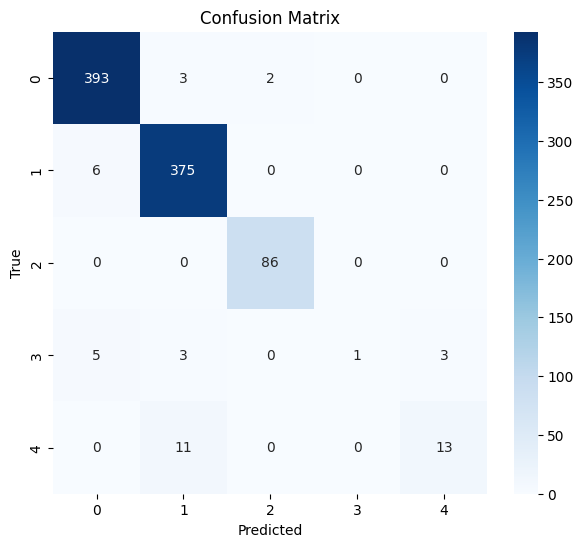

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       398
           1       0.96      0.98      0.97       381
           2       0.98      1.00      0.99        86
           3       1.00      0.08      0.15        12
           4       0.81      0.54      0.65        24

    accuracy                           0.96       901
   macro avg       0.94      0.72      0.75       901
weighted avg       0.96      0.96      0.96       901



In [75]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

# Set model to eval mode
model.eval()

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batch prediction
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Collect predictions
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# Plot confusion matrix and classification report
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False, cmap='Blues')
    ax.set_ylim(len(labels), 0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

# Show results
print_confusion_matrix(all_targets, all_preds)


In [76]:
# Save only the weights
torch.save(model.state_dict(), "model/keypoint_classifier/keypoint_classifier_weights.pth")


In [77]:
from model.keypoint_classifier.keypoint_classifier_pyt import KeyPointClassifier

  # your model definition
import torch

# Rebuild the model architecture
model = KeypointClassifier()

# Load the saved weights
model.load_state_dict(torch.load("model/keypoint_classifier/keypoint_classifier_weights.pth"))
model.eval()


# Prepare input tensor (e.g., one sample from X_test)
input_tensor = torch.tensor([X_test[0]], dtype=torch.float32)

# Inference
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1).squeeze()
    predicted_class = torch.argmax(probs).item()

# Output results
print(probs.numpy())
print(predicted_class)


[4.0818788e-02 9.4454193e-01 2.1285934e-05 1.1034387e-02 3.5836650e-03]
1


C:\Users\houci\AppData\Local\Temp\ipykernel_12872\3493685169.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/keypoint_classifier